# Pre-Installation

This first cell will crash the kernel on purpose to reset it.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


After the kernel has crashed run the following:

# Installation

In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
condacolab.install_anaconda()

✨🍰✨ Everything looks OK!


`conda create -n enterprise python=3.7`

`conda activate enterprise`

`conda install -c aarondjohnson -c conda-forge -q enterprise_extensions`

will install this on a personal computer with anaconda/miniconda with its own environment.

In [3]:
!conda install -c aarondjohnson -c conda-forge -q enterprise_extensions

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - enterprise_extensions


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |           1_llvm           5 KB  conda-forge
    acor-1.0.2                 |   py37hb93dfd8_2          13 KB  aarondjohnson
    alsa-lib-1.2.3             |       h516909a_0         560 KB  conda-forge
    argon2-cffi-20.1.0         |   py37h5e8e339_2          47 KB  conda-forge
    arviz-0.11.2               |     pyhd8ed1ab_1         1.4 MB  conda-forge
    astropy-4.2.1              |   py37h5e8e339_0         7.5 MB  conda-forge
    async_generator-1.10       |             py_0          18 KB  conda-forge
    attrs-21.2.0               |     pyhd8ed1ab_0          44 KB  conda-forge
    backcall-0.2.0             |     pyh9f0ad1d_0          13 KB  conda-forge


In [4]:
!rm -rf gwanw
!git clone https://github.com/aarondjohnson/gwanw

Cloning into 'gwanw'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 105 (delta 42), reused 105 (delta 42), pack-reused 0
Receiving objects: 100% (105/105), 23.22 MiB | 22.48 MiB/s, done.
Resolving deltas: 100% (42/42), done.


# Single Pulsar Analysis

## Import modules

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

## Load Pulsar

In [3]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = './data'

In [4]:
# get only J1909:
psrname = 'J1909'
parfiles = sorted(glob.glob(datadir + '/par/' + psrname + '*par'))
timfiles = sorted(glob.glob(datadir + '/tim/' + psrname + '*tim'))

print(parfiles)
print(timfiles)

['./data/par/J1909-3744_NANOGrav_12yv3.gls.par']
['./data/tim/J1909-3744_NANOGrav_12yv3.tim']


In [5]:
psrs = []
ephemeris = 'DE438'  # specify solar system ephemeris to compute Roemer delay with
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

## Look at the data

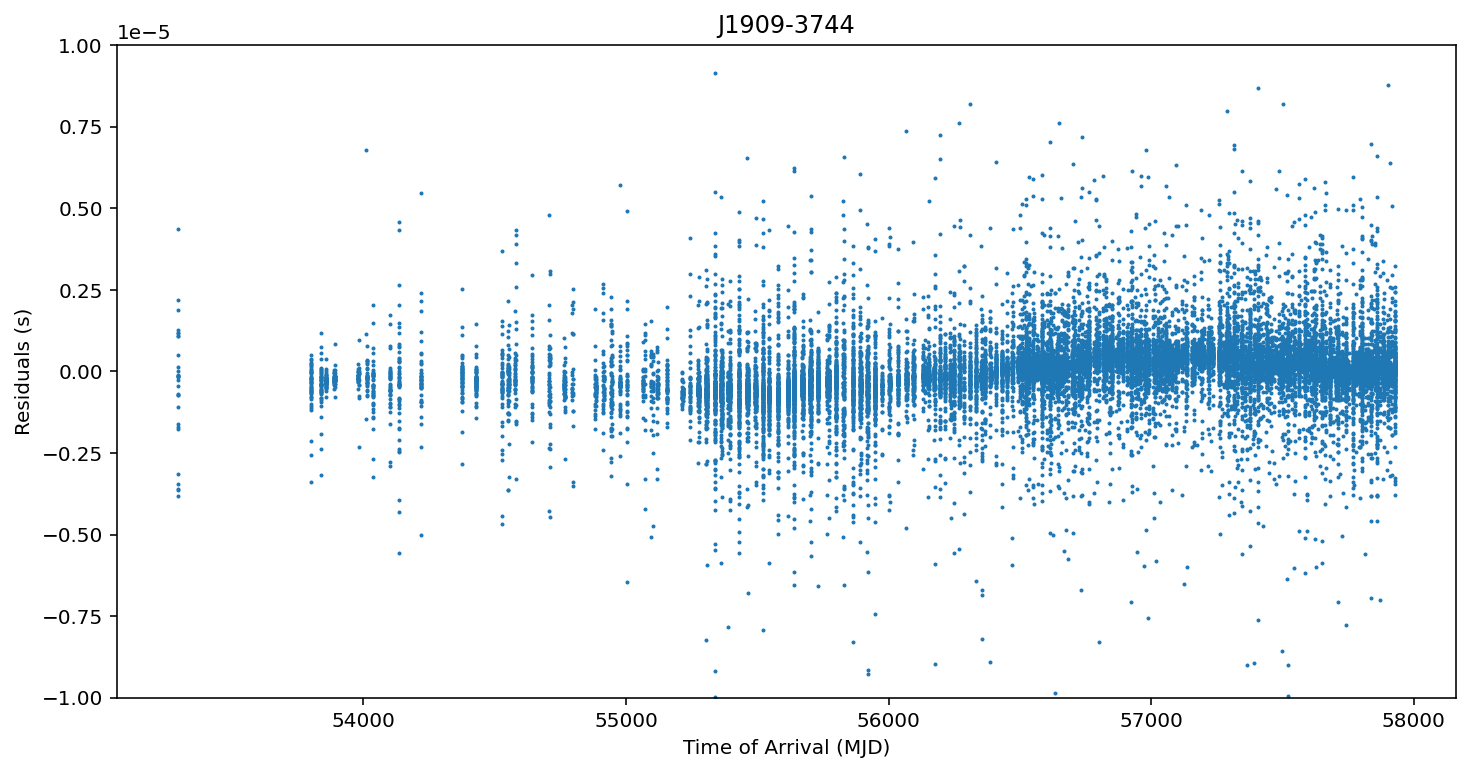

In [6]:
psr = psrs[0]
plt.figure(figsize=(12, 6))
plt.scatter(psr.toas / 86400, psr.residuals, s=1)
plt.title(psr.name)
plt.xlabel('Time of Arrival (MJD)')
plt.ylabel('Residuals (s)')
plt.ylim([-1e-5, 1e-5])
plt.show()

## Load noise files

In [8]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

In [9]:
# print receiver and backends + red noise
n = 0
for key in params:
    if 'J1909' in key:
        n += 1
        print(key)
print()
print('Number of params:', n)

J1909-3744_Rcvr1_2_GASP_efac
J1909-3744_Rcvr1_2_GASP_log10_ecorr
J1909-3744_Rcvr1_2_GASP_log10_equad
J1909-3744_Rcvr1_2_GUPPI_efac
J1909-3744_Rcvr1_2_GUPPI_log10_ecorr
J1909-3744_Rcvr1_2_GUPPI_log10_equad
J1909-3744_Rcvr_800_GASP_efac
J1909-3744_Rcvr_800_GASP_log10_ecorr
J1909-3744_Rcvr_800_GASP_log10_equad
J1909-3744_Rcvr_800_GUPPI_efac
J1909-3744_Rcvr_800_GUPPI_log10_ecorr
J1909-3744_Rcvr_800_GUPPI_log10_equad
J1909-3744_red_noise_gamma
J1909-3744_red_noise_log10_A

Number of params: 14


In [10]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

## Code to be used in model:

Get maximum time span to set GW frequency sampling

In [11]:
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

Create parameters

In [14]:
# white noise parameters
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18, -12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

Create signals to be used in model

In [15]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
# Note that the number of components here is changed to line up with the search in the full PTA search
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=5, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel(use_svd=False)

In [16]:
# full model
s = ef + eq + ec + rn + tm + gw

In [17]:
models = []

for p in psrs:
    models.append(s(p))

pta = signal_base.PTA(models)

In [18]:
# set white noise parameters with dictionary
pta.set_default_params(params)

## Play with the pta object

In [19]:
pta.params

[J1909-3744_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1909-3744_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 log10_A_gw:Uniform(pmin=-18, pmax=-12)]

In [20]:
pta.get_lnlikelihood([4, -15, -15])

304339.59735063155

In [21]:
pta.get_lnprior([4, -15, -15])

-5.934894195619588

## Sampling with PTMCMCSampler

In [22]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [23]:
# set up the sampler:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = '../chains_pta_gwb'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
                 outDir=outDir, resume=True)

In [34]:
# sampler for N steps (this should take about 15 mins.)
N = int(1e5)  # normally, we would use 5e6 samples (this will save time)
x0 = np.hstack([p.sample() for p in pta.params])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

/usr/local/lib/python3.7/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 42.885441 s Acceptance rate = 0.4994Adding DE jump with weight 50
Finished 99.00 percent in 379.038862 s Acceptance rate = 0.234586
Run Complete


## Check out the chains!

In [35]:
chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))
burn = int(0.25 * chain.shape[0])
ind = list(pta.param_names).index('log10_A_gw')

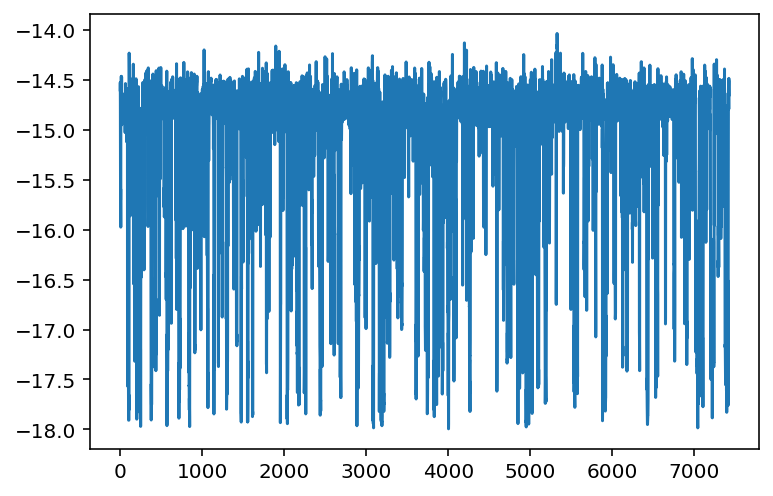

In [37]:
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])
plt.show()

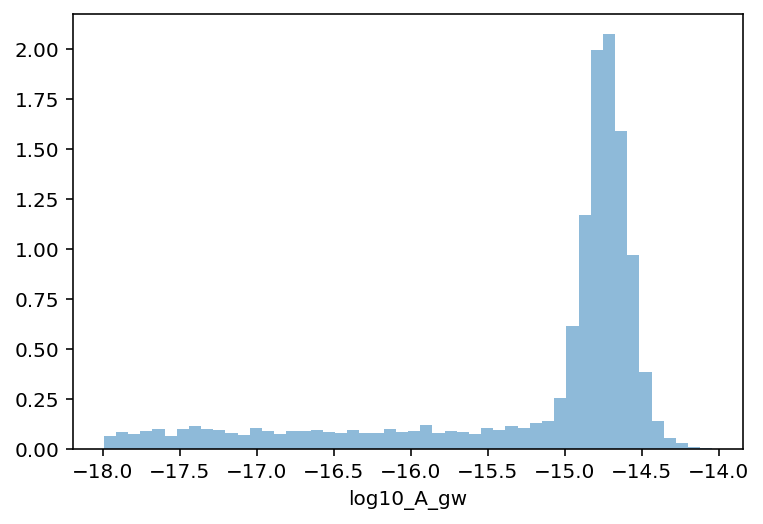

In [39]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 50, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.show()

## Model Selection

In [12]:
import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

In [13]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_1(psrs, psd='powerlaw', noisedict=params)
pta[1] = models.model_2a(psrs, psd='powerlaw', noisedict=params, n_gwbfreqs=5, gamma_common=13/3)

In [14]:
super_model = hypermodel.HyperModel(pta)

In [15]:
outDir = './gwanw_ms_chains'
sampler = super_model.setup_sampler(resume=True, outdir=outDir, sample_nmodel=True,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...

/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [16]:
# This will take about an hour to sample
# To sample it properly will take ~30 hours
# sampler for N steps
N = int(5e6)  # 5e6 is a good number for a real analysis 
x0 = super_model.initial_sample()

In [17]:
# sample
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.7/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))
Finished 0.20 percent in 27.905173 s Acceptance rate = 0.4426Adding DE jump with weight 50
Finished 50.44 percent in 7089.356149 s Acceptance rate = 0.425552

KeyboardInterrupt: 

In [19]:
chain = np.loadtxt(outDir + '/chain_1.txt')
burn = int(0.25 * chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

In [20]:
n_idx = list(pars).index('nmodel')

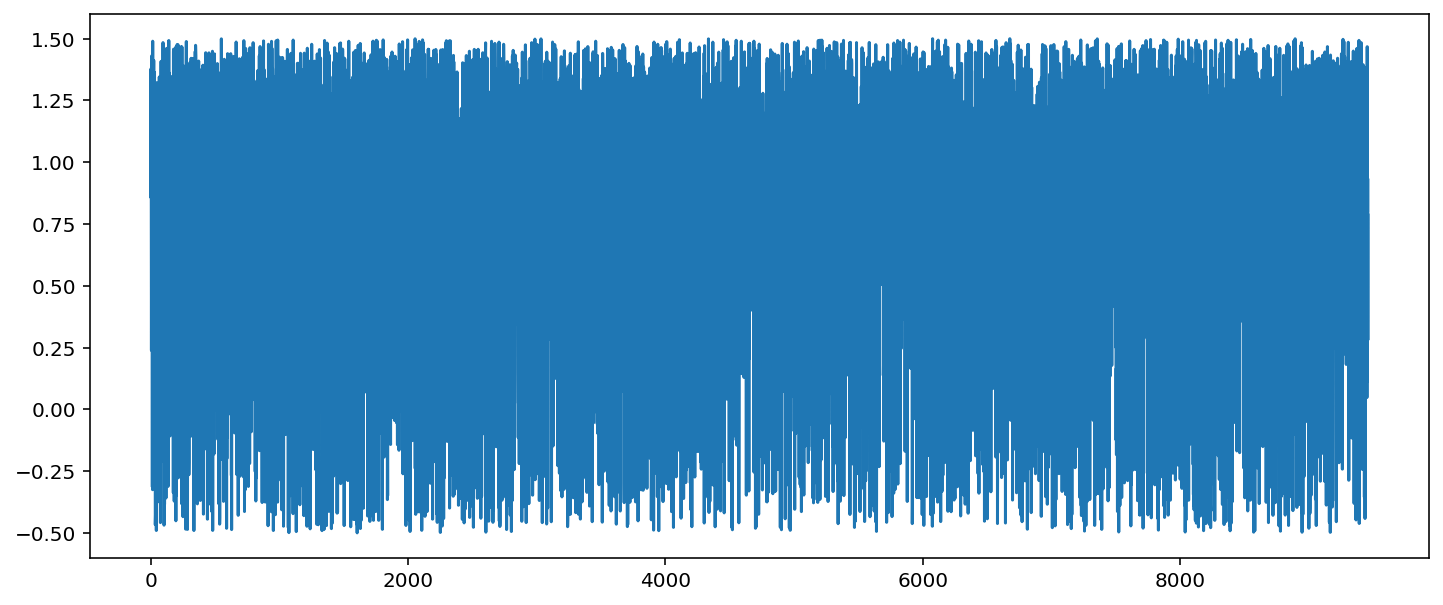

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(chain[burn::trim, n_idx])

In [55]:
trim = 20
len(np.where(chain[burn::trim, n_idx] > 0.5)[0]) / len(np.where(chain[burn::trim, n_idx] < 0.5)[0])

2.73686290003951

In [56]:
chain[burn::trim,:].shape

(9458, 8)

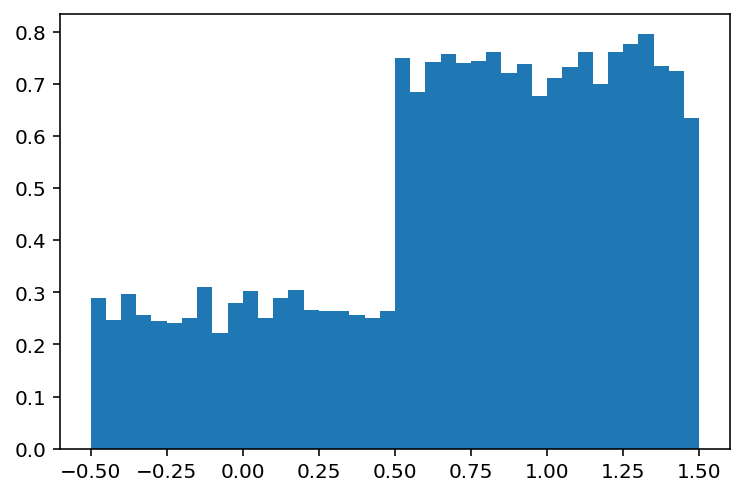

In [58]:
# Plot histogram for GWB model selection
# This will tell us how much we have sampled for each model
plt.hist(chain[burn::trim, n_idx], bins=40, density=True);

In [24]:
import acor

In [35]:
gw_idx = 2

In [31]:
print(np.where(chain[burn:, n_idx] > 0.5)[0])

[     0      1      2 ... 189147 189148 189149]


In [47]:
acor.acor(chain[np.where(chain[burn::, n_idx] > 0.5)[0], n_idx])

(6.653571372598508, 0.7317765398934588, 0.003655812703779933)

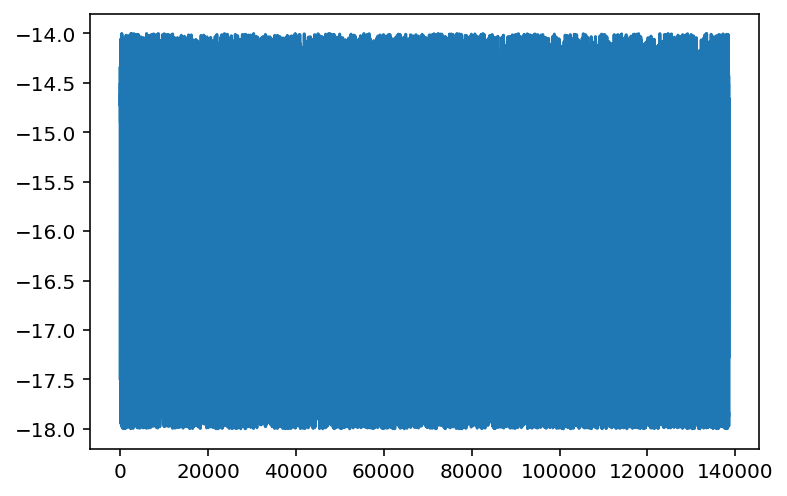

In [49]:
plt.plot(chain[np.where(chain[burn:, n_idx] > 0.5)[0], gw_idx])

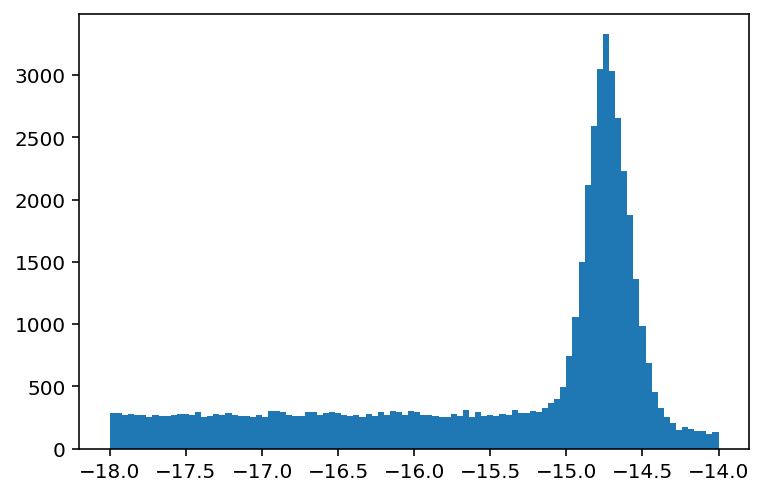

In [43]:
plt.hist(chain[np.where(chain[burn:, n_idx] < 0.5)[0], gw_idx], bins=100)
plt.show()

In [40]:
print(pars)

['J1909-3744_red_noise_gamma' 'J1909-3744_red_noise_log10_A' 'gw_log10_A'
 'nmodel']


In [60]:
np.savez_compressed(outDir + '/chain_1.npz', chain[::trim,:])

In [62]:
chain = np.load(outDir + '/chain_1.npz')['arr_0']

In [63]:
chain

array([[ 3.65956011e+00, -1.94889381e+01, -1.74894349e+01, ...,
         3.03871028e+05,  3.76000000e-01,  1.00000000e+00],
       [ 5.94626339e-01, -1.41898326e+01, -1.47647634e+01, ...,
         3.04343384e+05,  3.76000000e-01,  1.00000000e+00],
       [ 3.75435363e+00, -1.99787248e+01, -1.43371155e+01, ...,
         3.04337199e+05,  3.76000000e-01,  1.00000000e+00],
       ...,
       [ 4.20968530e-01, -1.41584154e+01, -1.48025162e+01, ...,
         3.04343551e+05,  4.25552000e-01,  1.00000000e+00],
       [ 4.21557381e+00, -1.47038842e+01, -1.76833215e+01, ...,
         3.04341266e+05,  4.25552000e-01,  1.00000000e+00],
       [ 3.42065332e+00, -1.42180383e+01, -1.79351415e+01, ...,
         3.04341221e+05,  4.25552000e-01,  1.00000000e+00]])

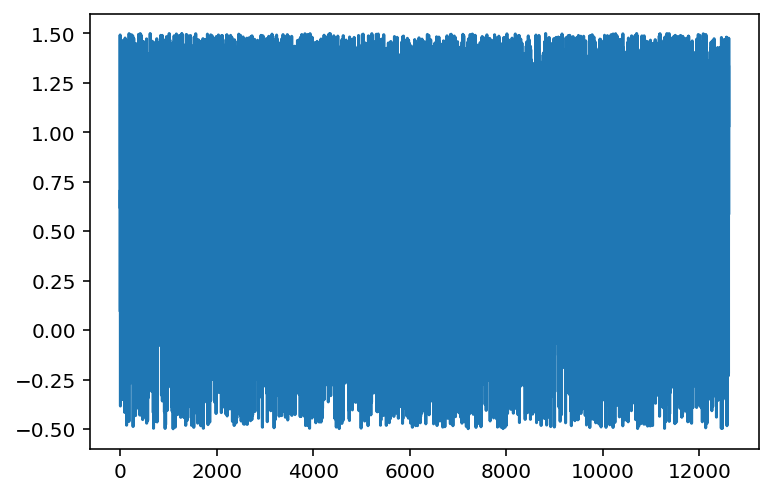

In [64]:
plt.plot(chain[:, n_idx])